# Analiza książek Jane Austen

1. Emma - powieść opowiadająca historię tytułowej bohaterki, Emmy Woodhouse - młodej i pewnej siebie damie, która bawi się w swaty i manipuluje życiem innych ludzi. Jednak jej pewność siebie zostaje wystawiona na próbę, gdy jej eksperymenty miłosne prowadzą do nieporozumień, błędnych ocen i tragicznych konsekwencji. Ksiązka jest pełna subtelnej ironii i ostrego spojrzenia na życie społeczne, a jednocześnie przedstawia rozwój i dojrzałość głównej bohaterki, która ostatecznie uczy się sztuki empatii i zrozumienia innych ludzi.

2. Perswazje (ang. Persuasion) - powieść skupiająca się na historii Anny Elliot, starszej panny, która po latach spotyka swojego dawno utraconego kochanka, kapitana Wentwortha. To historia o przezwyciężaniu przeszkód społecznych, przebaczeniu i drugiej szansie w miłości, wpisana w charakterystyczny styl Austen, pełen spostrzeżeń, dowcipu i obserwacji dotyczących społeczeństwa.

3. Rozważna i romantyczna (ang. Sense and Sensibility) - powieść przedstawia historię dwóch sióstr, Elinor i Marianne Dashwood, które stają w obliczu różnych wyzwań miłosnych. Książka porusza tematykę miłości, małżeństwa i różnic między rozsądkiem a uczuciami. Dodatkowo ukazuje społeczne konwenanse i ograniczenia, z którymi muszą zmierzyć się bohaterki.
Bohaterkami są dwie siostry Elinor oraz Marinne, które prezentują kontrast między rozważnym podejściem starszej z sióstr a burzliwymi emocjami młodszej.

## Przygotowanie środowiska

In [21]:
import nltk
nltk.download('gutenberg')
from nltk.corpus import gutenberg
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
import requests
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import os
import gensim
from textblob import TextBlob
from gensim.corpora.dictionary import Dictionary
from gensim.models import TfidfModel


[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Ania\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


## Pobranie książek

In [4]:
emma = gutenberg.raw('austen-emma.txt')
persuasion = gutenberg.raw('austen-persuasion.txt')
sense = gutenberg.raw('austen-sense.txt')

## Normalizacja tekstu

In [13]:
def clean_book(book):
    book = re.sub("\s{2,}", " ", book)
    book = book.lower()
    book = re.sub(r'[^\w\s]', '', book) # Usuwa znaki specjalne
    book = re.sub(r'\d+', '', book)     # Usuwa cyfry
    book = re.sub(r'_[^\s]+', '', book) # Usuwa słowa po _
    book = re.sub("\n", " ", book)  # Usuwa znaki nowej linii
    book = re.sub("\n\n", " ", book)  
    book = re.sub("\s{2,}", " ", book) 
    book = book.strip()

    return book

cleaned_emma = clean_book(emma)
cleaned_persuasion = clean_book(persuasion)
cleaned_sense = clean_book(sense)

## Tokenizacja

In [14]:
tokens_emma = word_tokenize(cleaned_emma)
tokens_persuasion = word_tokenize(cleaned_persuasion)
tokens_sense = word_tokenize(cleaned_sense)

## Stop lista

#### Zastosowano stoplistę z biblioteki Spacy ze względu, iż zawiera dużo większą liczbę słów. 

In [15]:
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words 

terms_emma = [el for el in tokens_emma if el not in stopwords]
terms_persuasion = [el for el in tokens_persuasion if el not in stopwords]
terms_sense = [el for el in tokens_sense if el not in stopwords]

## Stemming

In [16]:
stemmer = SnowballStemmer("english")

terms_stem_emma = [stemmer.stem(el) for el in terms_emma]
terms_stem_persuasion = [stemmer.stem(el) for el in terms_persuasion]
terms_stem_sense = [stemmer.stem(el) for el in terms_sense]


## Manualna stop lista

#### Dodatkowo manualnie usunięto słowa, które pojawiają się często a nie mają znaczenia dla zdania oraz resztki słów, których znaczenie zostało zatracone po stemmingu. Dodatkowo usunięto imię oraz nazwisko autorki, które mogło pojawić się w tekście. 

In [17]:
stoplist = ['volum','unit', 'vex', 'miss', 'be', 'mr', 'mrs', 'chapter', 'veri', "sir", "idl", "esq", "paragraph", "page", "much", "jane", "austen"]

terms_stem_emma = [el for el in terms_stem_emma if el not in stoplist]
terms_stem_persuasion = [el for el in terms_stem_persuasion if el not in stoplist]
terms_stem_sense = [el for el in terms_stem_sense if el not in stoplist]

## Zliczenie wystąpień

In [8]:
def counting_collections(termy, amount):
    unikaty = list(set(termy))
    bow = {unikat: termy.count(unikat) for unikat in unikaty}
    bow_naj = {unikat: liczba for unikat, liczba in bow.items() if liczba >= amount}
    bow_naj_sort = {unikat: liczba for unikat, liczba in sorted(bow_naj.items(), key=lambda el: el[1])}

    return bow_naj_sort

## Najczęściej występujące termy

#### Dla każdej z książek

In [10]:
bow_naj_sort_emma = counting_collections(terms_stem_emma, 250)
bow_naj_sort_persuasion = counting_collections(terms_stem_persuasion, 120)
bow_naj_sort_sense = counting_collections(terms_stem_sense, 150)

#### Tylko dla książki "Emma"

In [11]:
terms_only_emma = [el for el in terms_stem_emma if el not in terms_stem_persuasion and el not in terms_stem_sense]
bow_naj_sort_only_emma = counting_collections(terms_only_emma, 50)

#### Tylko dla książki "Persuasion"

In [12]:
terms_only_persuasion = [el for el in terms_stem_persuasion if el not in terms_stem_emma and el not in terms_stem_sense]
bow_naj_sort_only_persuasion = counting_collections(terms_only_persuasion, 50)

#### Tylko dla książki "Sense and Sensibility"

In [13]:
terms_only_sense = [el for el in terms_stem_sense if el not in terms_stem_emma and el not in terms_stem_persuasion]
bow_naj_sort_only_sense = counting_collections(terms_only_sense, 50)

#### Termy dla wszystkich książek

In [14]:
terms_all = [el for el in terms_stem_emma if el in terms_stem_persuasion and el in terms_stem_sense]
bow_naj_sort_all = counting_collections(terms_all, 235)

## Wizualizacja

### Wykres termów najczęściej występujących w książce "Emma"

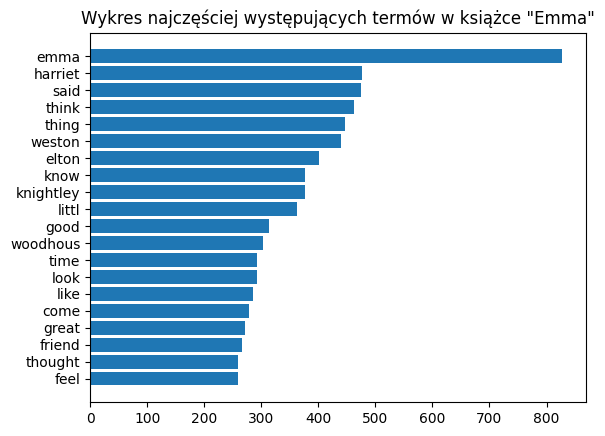

In [23]:
plt.barh(range(len(bow_naj_sort_emma)), bow_naj_sort_emma.values(), align='center')
plt.yticks(range(len(bow_naj_sort_emma)), list(bow_naj_sort_emma.keys()))
plt.title('Wykres najczęściej występujących termów w książce "Emma"')
plt.show()

Najczęściej występującym słowem w książce "Emma" jest imie tytułowej bohaterki i występuje aż ponad 800 razy. Bardzo popularne słowa w tej książce to "Harriet", "said", "think", "thing" oraz "Weston" i występują około 500 razy w tej powieści. W okolicach 400 wystąpień znajdujemy słowa "Elton", "know", "Knightley" oraz "littl" (little). Pozostałe najczęściej występujące słowa pojawiają się częściej niż 250 razy.

### Wykres termów najczęściej występujących w książce "Persuasion"

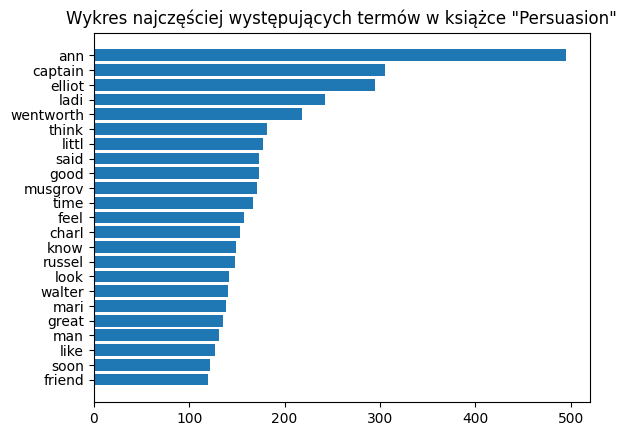

In [22]:
plt.barh(range(len(bow_naj_sort_persuasion)), bow_naj_sort_persuasion.values(), align='center')
plt.yticks(range(len(bow_naj_sort_persuasion)), list(bow_naj_sort_persuasion.keys()))
plt.title('Wykres najczęściej występujących termów w książce "Persuasion"')
plt.show()

Najczęściej występującym słowem w książce "Persuasion" jest imie głównej bohaterki "Ann" i występuje około 500 razy. Słowa występujące ponad 300 razy to "captain" oraz "Eliot". Kapitan jest to drugi z głównych bohaterów, natomiast słowo "Eliot" to nazwisko głównej bohaterki.
Powyżej 200 razy pojawiają się słowa "ladi" (lady) oraz "Wentworth" i oba dotyczą opisu bohaterów. Pozostałe najczęściej występujące słowa pojawiają się częściej niż 120 razy.

### Wykres termów najczęściej występujących w książce "Sense and Sensibility"

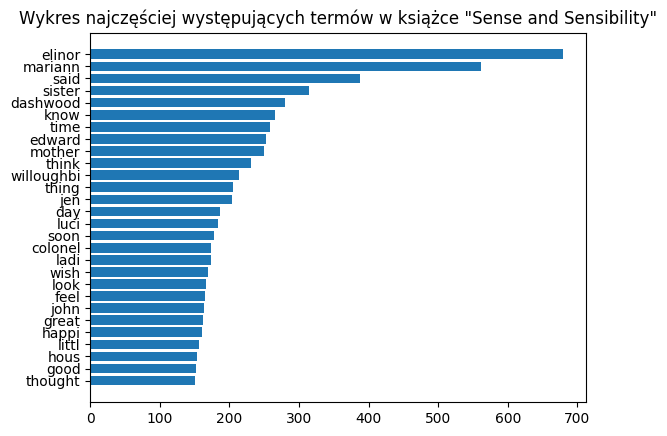

In [21]:
plt.barh(range(len(bow_naj_sort_sense)), bow_naj_sort_sense.values(), align='center')
plt.yticks(range(len(bow_naj_sort_sense)), list(bow_naj_sort_sense.keys()))
plt.title('Wykres najczęściej występujących termów w książce "Sense and Sensibility"')
plt.show()

Najczęściej występującym słowem w książce "Sense and Sensibility" jest imie jednej z głównych bohaterek - starszej siostry "Elinor". Pojawia się ono około 700 razy. Kolejno około 550 razy występuje imie młodszej z sióstr "Mariann" (Marianne). Ponad 400 razy występuje słowo "said", które jest często używanym słowem w powieściach w celu poinformowania czytelnika, który z bohaterów wypowiedział dane zdanie. Słowo "sister" występuje ponad 300 razy, co nie jest zaskakującym, ze względu na stopień pokrewieństwa dwóch głównych bohaterek. Pozostałe najczęściej występujące słowa pojawiają się w tekście ponad 150 razy. 

##### Podsumowując, w badanych książkach najczęściej pojawiają się imiona oraz nazwiska bohaterów. Dodatkowo można zaobserwować słowa określające bohatera takie jak mother, sister, ladi (lady). W książkach "Emma" oraz "Sense and Sensibility" często pojawia się słowo "good" oraz "thought". W książce "Persuasion" można zaobserwować podobną częstość występowania słowa "great". Również słowo "time" pojawia się często w dwóch z analizowanych książek ("Emma", "Persuasion"). We wszystkich analizowanych książkach pojawia się również przymiotnik "littl" (little).

### Wykres termów pojawiających się najczęsciej w książce "Emma", a nie pojawiających się w pozostałych książkach

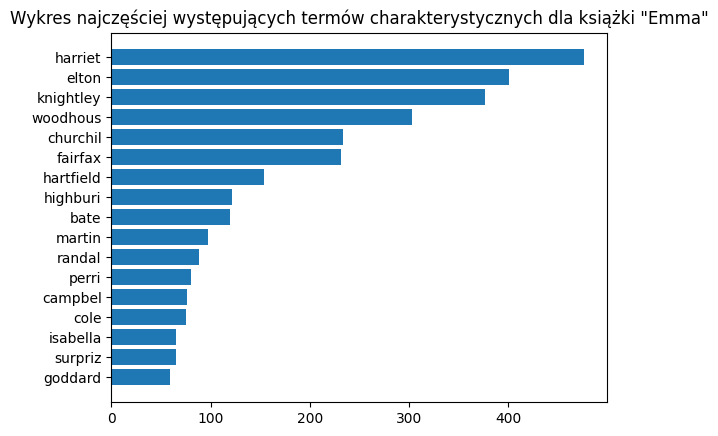

In [24]:
plt.barh(range(len(bow_naj_sort_only_emma)), bow_naj_sort_only_emma.values(), align='center')
plt.yticks(range(len(bow_naj_sort_only_emma)), list(bow_naj_sort_only_emma.keys()))
plt.title('Wykres najczęściej występujących termów charakterystycznych dla książki "Emma"')
plt.show()

Jak można zauważyć na wykresie, słowo "Emma" mimo, iż było najczęściej pojawiającym się słowem dla tej książki, nie jest słowem jednoznacznie determinującym tę książkę. Natomiast, drugie z najpopularniejszych słów pojawia się na obu wykresach co oznacza, że jest słowem charakterystycznym dla tej pozycji. Pozostałe najczęściej występujące słowa, które są charakterystyczne dla książki "Emma" to imiona bądź nazwiska bohaterów

### Wykres termów pojawiających się najczęściej w książce "Persuasion", a nie pojawiających się dla innych książek

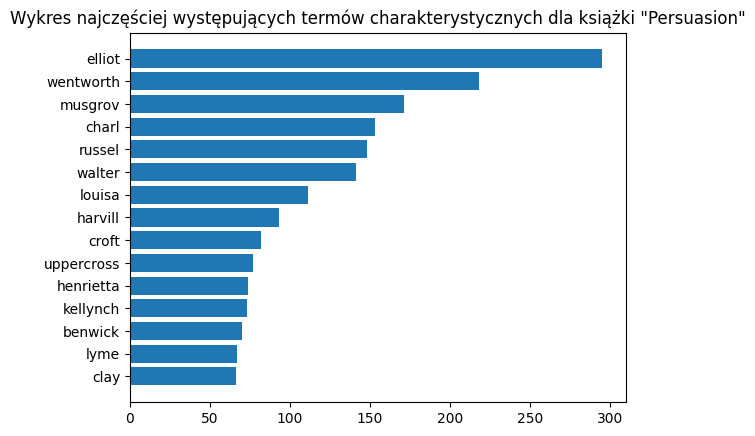

In [25]:
plt.barh(range(len(bow_naj_sort_only_persuasion)), bow_naj_sort_only_persuasion.values(), align='center')
plt.yticks(range(len(bow_naj_sort_only_persuasion)), list(bow_naj_sort_only_persuasion.keys()))
plt.title('Wykres najczęściej występujących termów charakterystycznych dla książki "Persuasion"')
plt.show()

Najczęściej występującym słowem charakterystycznym dla powieści "Persuasion" jest nazwisko głównej bohaterki - "Eliot". Podobnie jak poprzednio dwa najczęściej występujące słowa ("ann" oraz "captain") nie są słowami charakterystycznymi dla tej książki. Pozostałe słowa charakterystyczne dla tej pozycji których częstość wystąpień wynosi ponad 50 to imiona i nazwiska bohaterów oraz nazwy własne (np. "uppercross" - prawdopodobnie nazwa ulicy). 

### Wykres termów pojawiających się najczęściej dla książki "Sense and Sensibility", a nie pojawiających się dla innych książek

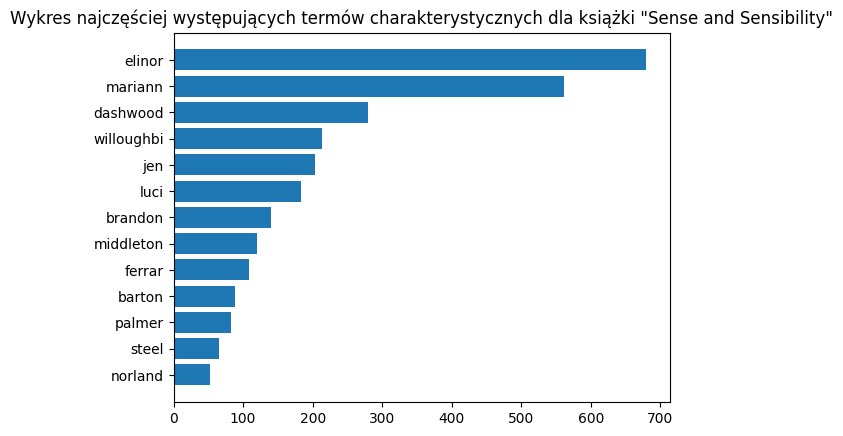

In [26]:
plt.barh(range(len(bow_naj_sort_only_sense)), bow_naj_sort_only_sense.values(), align='center')
plt.yticks(range(len(bow_naj_sort_only_sense)), list(bow_naj_sort_only_sense.keys()))
plt.title('Wykres najczęściej występujących termów charakterystycznych dla książki "Sense and Sensibility"')
plt.show()

Najczęściej występujące słowa dla powieści "Sense and Sensibility" są też najczęściej występującymi słowami charakterystycznymi dla tej książki. Są to imiona głównych bohaterek "Elinor" oraz "Mariann" (Marianne). Pozostałe najczęściej występujące termy charakterystyczne dla tej książki to tak jak w pozostałych przypadkach głównie imiona lub nazwiska bohaterów. 

##### Ograniczając najczęściej występujące słowa badanych książek do słów charakterystycznych dla konkretnej książki, tj. słów, które pojawiają się tylko w jednej książce a nie pojawiają się w pozostałych książkach obserwujemy, że najczęściej pojawiające się słowa to imiona lub nazwiska bohaterów. Bez tego ograniczenia obserwowano również inne słowa takie jak np. "good", "great", "thought" oraz "time", czyli słowa, które można uznać za popularne.

### Wykres najczęściej występujących słów we wszystkich książkach

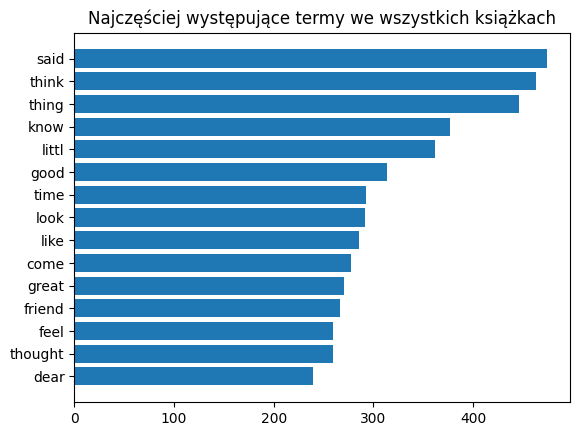

In [27]:
plt.barh(range(len(bow_naj_sort_all)), bow_naj_sort_all.values(), align='center')
plt.yticks(range(len(bow_naj_sort_all)), list(bow_naj_sort_all.keys()))
plt.title('Najczęściej występujące termy we wszystkich książkach')
plt.show()

Na liście najpopularniejszych słów dla wszystkich książek pojawiają się słowa wymienione wcześniej - takie jak "great", "good", "thought", "time" czy "littl" (little). Najpopularniejszym słowem we wszystkich książkach jest słowo "said", a następnie słowo "think", co nie jest zaskakujące z racji charakteru książki, gdzie często pojawiają się opisy kto co powiedział lub pomyślał. 

## Chmura wyrazów

### Chmura słów najczęściej występujących termów dla książki "Emma"

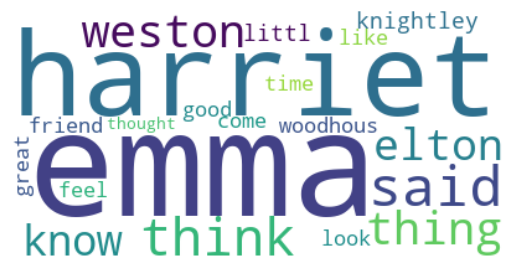

In [28]:
wordcloud = WordCloud(background_color="white").generate_from_frequencies(bow_naj_sort_emma)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Jak widać na chmurze słów najczęściej pojawiają się termy "emma" oraz "harriet". Są to imiona głównych bohaterek książki. 
W książce znajdują się dialogi oraz przemyślenia bohaterów stąd pojawiają się słowa "said" lub "think". Imiona lub nazwiska pozostałych bohaterów również często się pojawiają.  
Pozostałe słowa pojawiające się na chmurze słowa nie są termami specyficznymi. Są to słowa popularne dla wielu tekstów, co może powodować trudności w dalszej klasyfikacji tej książki. 

### Chmura słów dla najczęściej występujących termów dla książki "Persuasion"

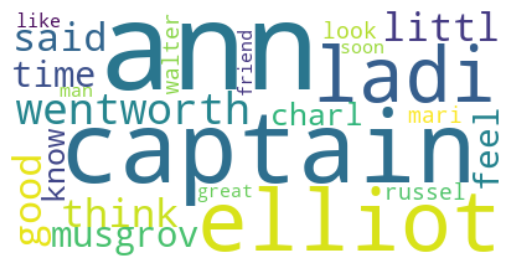

In [29]:
wordcloud = WordCloud(background_color="white").generate_from_frequencies(bow_naj_sort_persuasion)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Dla książki "Persuasion" najpopularniejszymi słowami są "ann", "captain", "elliot", "ladi" oraz "wentworth". Są to imiona lub opisy bohaterów. Następnie często pojawiają się słowa "said" oraz "think", co zostało już przeanalizowane powyżej. Do listy słów niespecyficznych można dołączyć słowa "feel", "good" oraz "littl" (little). Są to bardzo powszechne słowa i nie są charakterystyczne tylko dla jednej książki bądź tekstu. 

### Chmura słów dla najczęściej występujących termów dla książki "Sense and Sensibility"

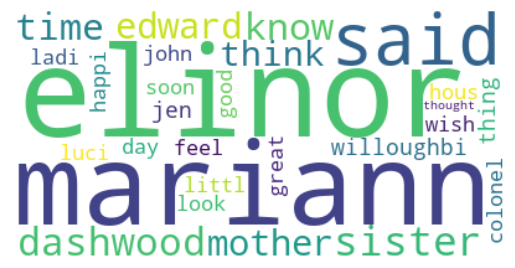

In [30]:
wordcloud = WordCloud(background_color="white").generate_from_frequencies(bow_naj_sort_sense)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Podobnie jak dla pozostałych pozycji najczęściej występujące słowa to imiona lub nazwiska bohaterów takie jak "mariann", "elinor", "edward" czy "dashwood". Dodatkowo książka opowiada historię dwóch sióstr stąd popularnym słowem jest słowo "sistrer". Ważną dla książki bohaterką jest też matka - stąd częstym słowem jest słowo "mother". Następnie widać słowa omawiane dla dwóch poprzednich książek czyli "said" oraz "think". Częstym słowem jest też słowo "time", które również nie jest charakterystycznym słowem. 

##### Podsumowując, słowa, które mogą bezpośrednio charakteryzować książki to imiona bohaterów. Reszta często występujących słów to popularne przymiotniki lub czasowniki, które nie są charakterystyczne dla konkretnego tekstu. 

### Chmura słów dla najczęśćiej występujących termów we wszystkich analizowanych książkach

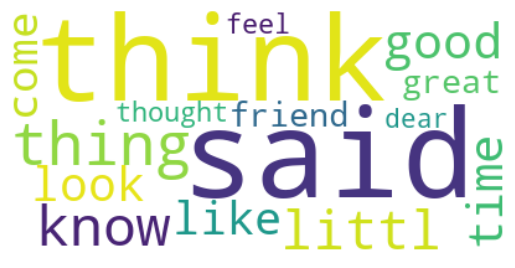

In [31]:
wordcloud = WordCloud(background_color="white").generate_from_frequencies(bow_naj_sort_all)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Słowa pojawiające się dla wszystkich książek to popularne czasowniki oraz przymiotniki. W książkach często pojawiają się opisy o tym kto co powiedział, pomyślał, wiedział czy poczuł - z tego względu pojawiają się termy takie jak "said", "think", "know" czy "feel". Dodatkowo częstym słowem w języku angielskim jest "time". Określenia czasu równie często pojawiają się w różnych książkach. Pozostałe słowa to głównie ppopularne przymiotniki lub rzeczowniki takie jak "little", "friend", "good" czy "great". 
Dodatkowo można zauważyć, że większość słów poza czasownikami są słowami, które można uznać za pozytywne, co może wpływać na dalszą analizę nastroju. 

## Macierz dokument-term

In [32]:
documents = [terms_stem_emma, terms_stem_persuasion, terms_stem_sense]
unikaty = list(set([term for document in documents for term in document]))
print(f'Wszystkich termów jest {sum(len(array) for array in documents)}, ale unikatowych jest {len(unikaty)}.')

Wszystkich termów jest 131418, ale unikatowych jest 9029.


In [33]:
def create_dtm(documents, unikaty):    
    matrix = np.zeros((len(documents), len(unikaty)), int)
    
    for doc_idx, document in enumerate(documents):
        for term in document:
            term_idx = unikaty.index(term)
            matrix[doc_idx, term_idx] += 1
                    
    return matrix

In [34]:
doc_term_matrix = create_dtm(documents, unikaty)
print(doc_term_matrix)

[[17  1  0 ...  1 10  0]
 [ 7  0  0 ...  0  1  0]
 [ 4  0  2 ...  0  9  1]]


In [35]:
term_doc_matrix = np.transpose(doc_term_matrix)
print(term_doc_matrix)

[[17  7  4]
 [ 1  0  0]
 [ 0  0  2]
 ...
 [ 1  0  0]
 [10  1  9]
 [ 0  0  1]]


#### Rozkład najliczniejszych termów

In [55]:
suma_col=doc_term_matrix.sum(axis=0)
bow = list(zip(unikaty, suma_col))
bow.sort(key=lambda el: el[1])

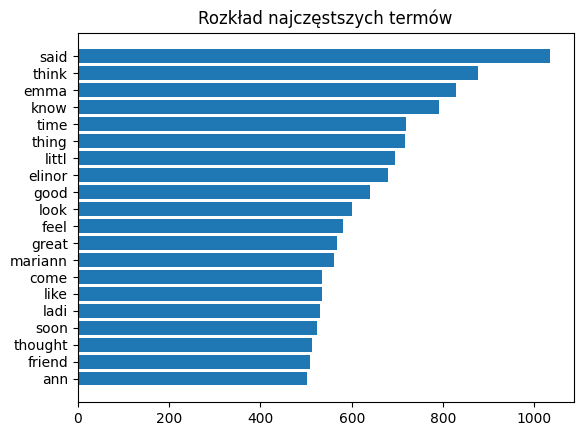

In [57]:
plt.barh(*zip(*bow[-20:]), align='center')
plt.title("Rozkład najczęstszych termów")
plt.show()

Jak można zaobserwować, najczęściej występującym termem jest term "said". W każdej z powieści pojawiają się dialogi, do których używane jest słówo "said" aby określić który bohater wypowiedział dane zdanie. Kolejnym termem pod względem częstości występowania jest term "think", które pojawia się równie często w różnych powieściach jako oznaczenie przemyśleń bohatera. Trzecim najpopularniejszym termem jest "Emma". Ten term pojawia się w książce "Emma" ponad 800 razy. 

## Analiza wątków

In [36]:
model_h = AgglomerativeClustering(n_clusters=None, distance_threshold = 0, metric = "euclidean", linkage ='ward')
model_h.fit_predict(doc_term_matrix)

array([1, 2, 0], dtype=int64)

In [37]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

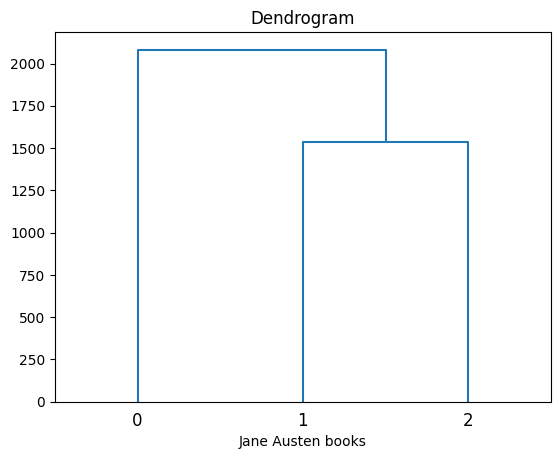

In [38]:
plt.title('Dendrogram')
plot_dendrogram(model_h, truncate_mode='level', p=3)
plt.xlabel("Jane Austen books")
plt.show()

Jak można zaobserwować na dendrogramie analizowane książki autorstwa Jane Austen można podzielić na dwie grupy, z czego druga z nich dzieli się na kolejne dwie. Taki wynik mówi nam o tym, że dwie książki są ze sobą powiązane wspólnym wątkiem. Natomiast jedna z nich obejmuje inny wątek.
Według tej analizy książka "Emma" (0) jest najmniej podobna do dwóch pozostałych książek. Książki "Persuasion" (1) oraz "Sense and Sensibility" (2) są uznane za podobne. Jednakże taka analiza dla tak małej ilości książek nie jest wiarygodna oraz nie daje jednoznacznych wyników. 

### LDA 

Latent Dirichlet Allocation (LDA) to popularny model do analizy tematycznej. LDA zakłada, że każdy dokument w korpusie jest kombinacją różnych tematów, a każde słowo w dokumencie jest przypisane do jednego z tych tematów. LDA jest modelem probabilistycznym i pozwala na odkrywanie ukrytych tematów, które wyjaśniają obecność pewnych słów w różnych dokumentach.

In [430]:
terms = terms_stem_emma + terms_stem_persuasion + terms_stem_sense

dictionary = corpora.Dictionary([terms])

# Tworzenie korpusu
corpus = [dictionary.doc2bow([sentence]) for sentence in terms]

#Model TF-IDF
tfidf = TfidfModel(corpus)

# tworzenie korpusu
corpus = [dictionary.doc2bow([sentence]) for sentence in terms]

In [431]:
num_topics = 3

# Tworzenie modelu LDA
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

# Wypisanie tematów
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.039*"elinor" + 0.031*"mariann" + 0.019*"said" + 0.018*"edward" + 0.017*"sister" + 0.017*"time" + 0.015*"dashwood" + 0.014*"think" + 0.014*"mother" + 0.009*"ferrar"')
(1, '0.015*"colonel" + 0.015*"luci" + 0.014*"thing" + 0.013*"jen" + 0.012*"soon" + 0.012*"happi" + 0.012*"brandon" + 0.010*"great" + 0.010*"friend" + 0.009*"good"')
(2, '0.017*"know" + 0.013*"day" + 0.012*"wish" + 0.012*"feel" + 0.011*"look" + 0.011*"willoughbi" + 0.010*"heart" + 0.010*"littl" + 0.010*"thought" + 0.010*"engag"')


Analiza modelu LDA wyodrębniła 3 tematy. 
W pierwszym z nich można zaobserwować imiona głównych bohaterek książki "Sense and Sensibility". Następnie widnieją termy takie jak: "edward", "sister", "dashwood" czy "mother" co również jest zbieżne z treścią tej książki. Pozostałe słowa wyodrębnione to "said", "think" czy "time", które pojawiały się w najczęściej występujących słowach dla tej książki. Wartości przed termami również poprawnie odwierciedlają częstość występowania tych słów dla książki "Sense and Sensibility". Można zatem stwierdzić, że model prawidłowo wykrył główny wątek tej powieści.  
Natomiast model drugi i trzeci są zbiorem losowych słów, z których ciężko wyodrębnić konkretny wątek. Można przypuszczać, że drugi z nich dotyczy przyjaźni. Trzeci może dotyczyć bohaterki "willoughbi", lecz również ze względu na dobór słów nie jest możliwe dokładniejsze przybliżenie jego. 
Oba natomiast zawierają termy przedstawiające imiona bohaterów książki "Sense and Sensibility" stąd można przypuszczać, że opisują poboczne wątki tej pozycji. 
Założenie 3 tematów miało na celu wykrycie głównych wątków dla każdej z analizowanych powieści. Niestety modelowanie nie spełniło tego założenia, co prawdopodobnie wynika z dużej dysproporcji danych tekstowych w zbiorze. Nie bez znaczenia jest również branie pod uwagę jedynie słów unikatowych. Wiele ze najczęściej występujących słów z książki "Emma" czy "Persuasion" nie są unikatowymi dla nich słowami. Stąd trudniej wykryć główne wątki tych książek. 

## Podział książek na rozdziały

W tym celu wykonano następujące kroki:
- Utworzono na dysku folder chapters a w nim podfoldery odpowiednio dla książek. 
- Podmieniono słowo CHAPTER na =-CHAPTER. 
- Następnie usunięto pierwszy element, który zawierał jedynie znak "=-".
- Wydzielono nazwe po znaku nowej linii. 
- Podmieniono space w nazwie na znak _ w celu lepszego zapisu (i późniejszego odczytu pliku). 
- Następnie utworzono pliki z nazwą rodziału i wpisano do nich zawartość odpowiedniego rozdziału

In [ ]:
formatted_text_emma = emma.replace('CHAPTER','=-CHAPTER')
split_text_emma = formatted_text_emma.split("=-")
del split_text_emma[0]

for i in split_text_emma:
    name_emma = i.split("\n\n")
    form_name_emma = name_emma[0].replace(" ", "_")
    
    with open (f"C:/Users/Ania/Desktop/chapters/chapters_emma/{form_name_emma}.txt","a+") as f:
        f.write(i)

In [ ]:
formatted_text_persuasion = persuasion.replace('Chapter','=-Chapter')
split_text_persuasion = formatted_text_persuasion.split("=-")
del split_text_persuasion[0]

for i in split_text_persuasion:
    name_persuasion = i.split("\n\n")
    form_name_persuasion = name_persuasion[0].replace(" ", "_")
    
    with open (f"C:/Users/Ania/Desktop/chapters/chapters_persuasion/{form_name_persuasion}.txt","a+") as f:
        f.write(i)

In [ ]:
formatted_text_sense = sense.replace('CHAPTER','=-CHAPTER')
split_text_sense = formatted_text_sense.split("=-")
del split_text_sense[0]

for i in split_text_sense:
    name_sense = i.split("\n\n")
    form_name_sense = name_sense[0].replace(" ", "_")
    
    with open (f"C:/Users/Ania/Desktop/chapters/chapters_sense/{form_name_sense}.txt","a+") as f:
        f.write(i)

## Stworzenie dataframe

In [39]:
def split_by_chapter(directory):
    chapters = []
    os.chdir(f"C:/Users/Ania/Desktop/chapters/{directory}")
    for filename in os.listdir(os.getcwd()):
        with open(os.path.join(os.getcwd(), filename), 'r') as f:
            text = f.read()
            text = clean_book(text)
            chapters.append(text)
    return chapters

#### dla książki "Emma"

In [40]:
chapters_emma = split_by_chapter('chapters_emma')
d_chapters_emma = {'text':chapters_emma}
df_emma = pd.DataFrame(data=d_chapters_emma)

#### dla książki "Persuasion"

In [41]:
chapters_persuasion = split_by_chapter('chapters_persuasion')
d_chapters_persuasion = {'text':chapters_persuasion}
df_persuasion = pd.DataFrame(data=d_chapters_persuasion)

#### dla książki "Sense and Sensibility"

In [42]:
chapters_sense = split_by_chapter('chapters_sense')
d_chapters_sense = {'text': chapters_sense}
df_sense = pd.DataFrame(data=d_chapters_sense)

#### przygotowanie termów z tekstów z df_emma

In [43]:
df_emma['text'] = df_emma['text'].apply(lambda x: clean_book(x))
df_emma['text'] = df_emma['text'].apply(lambda x: word_tokenize(x))
df_emma['text'] = df_emma['text'].apply(lambda x: [el for el in x if el not in stopwords])
df_emma['text'] = df_emma['text'].apply(lambda x: [stemmer.stem(el) for el in x])
stoplist=stoplist+['ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii',
                   'xiv', 'xv', 'xvi', 'xvii', 'xviii']
df_emma['text'] = df_emma['text'].apply(lambda x: [el for el in x if el not in stoplist])
df_emma

,text
0,"[emma, woodhous, handsom, clever, rich, comfor..."
1,"[weston, nativ, highburi, born, respect, famil..."
2,"[woodhous, fond, societi, way, like, friend, c..."
3,"[harriet, smith, intimaci, hartfield, soon, se..."
4,"[knightley, quarrel, emma, quarrel, displeas, ..."
5,"[know, opinion, weston, said, knightley, great..."
6,"[emma, feel, doubt, have, given, harriet, fanc..."
7,"[day, elton, go, london, produc, fresh, occas,..."
8,"[harriet, slept, hartfield, night, week, past,..."
9,"[middl, decemb, weather, prevent, young, ladi,..."


#### przygotowanie termów z tekstów z df_persuasion 

In [44]:
df_persuasion['text'] = df_persuasion['text'].apply(lambda x: clean_book(x))
df_persuasion['text'] = df_persuasion['text'].apply(lambda x: word_tokenize(x))
df_persuasion['text'] = df_persuasion['text'].apply(lambda x: [el for el in x if el not in stopwords])
df_persuasion['text'] = df_persuasion['text'].apply(lambda x: [stemmer.stem(el) for el in x])
stoplist=stoplist+['ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii',
                   'xiv', 'xv', 'xvi', 'xvii', 'xviii']
df_persuasion['text'] = df_persuasion['text'].apply(lambda x: [el for el in x if el not in stoplist])
df_persuasion

,text
0,"[walter, elliot, kellynch, hall, somersetshir,..."
1,"[opportun, make, observ, fail, occur, ann, soo..."
2,"[time, approach, ladi, russel, return, day, fi..."
3,"[ann, henrietta, find, earliest, parti, morn, ..."
4,"[remaind, ann, time, uppercross, comprehend, d..."
5,"[charl, mari, remain, lyme, longer, musgrov, g..."
6,"[walter, taken, good, hous, camden, place, lof..."
7,"[point, ann, return, famili, thank, ascertain,..."
8,"[walter, elizabeth, assidu, push, good, fortun..."
9,"[begin, februari, ann, have, month, bath, grow..."


#### przygotowanie termów z tekstów z df_sense

In [45]:
df_sense['text'] = df_sense['text'].apply(lambda x: clean_book(x))
df_sense['text'] = df_sense['text'].apply(lambda x: word_tokenize(x))
df_sense['text'] = df_sense['text'].apply(lambda x: [el for el in x if el not in stopwords])
df_sense['text'] = df_sense['text'].apply(lambda x: [stemmer.stem(el) for el in x])
stoplist=stoplist+['ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii',
                   'xiv', 'xv', 'xvi', 'xvii', 'xviii']
df_sense['text'] = df_sense['text'].apply(lambda x: [el for el in x if el not in stoplist])
df_sense

,text
0,"[famili, dashwood, long, settl, sussex, estat,..."
1,"[mariann, preserv, margaret, eleg, precis, sty..."
2,"[littl, dashwood, daughter, imagin, came, devo..."
3,"[elinor, mariann, walk, morn, communic, piec, ..."
4,"[intend, excurs, whitwel, turn, differ, elinor..."
5,"[sudden, termin, colonel, brandon, visit, park..."
6,"[dashwood, visit, ladi, middleton, took, place..."
7,"[mariann, thought, inexcus, abl, sleep, night,..."
8,"[dashwood, surpris, moment, see, come, barton,..."
9,"[elinor, saw, great, uneasi, low, spirit, frie..."


#### połączenie poszczególnych dataframe

In [46]:
combined_df = pd.concat([df_emma, df_persuasion, df_sense], ignore_index=True)
combined_df

,text
0,"[emma, woodhous, handsom, clever, rich, comfor..."
1,"[weston, nativ, highburi, born, respect, famil..."
2,"[woodhous, fond, societi, way, like, friend, c..."
3,"[harriet, smith, intimaci, hartfield, soon, se..."
4,"[knightley, quarrel, emma, quarrel, displeas, ..."
...,...
88,"[proper, resist, ferrar, violent, steadi, pres..."
89,"[journey, perform, melancholi, disposit, tedio..."
90,"[barton, park, half, mile, cottag, ladi, pass,..."
91,"[jen, widow, ampl, jointur, daughter, live, re..."


## Klasyfikacja

Klasyfikacje przeprowadzono dla wszystkich analizowanych książek jednocześnie.

#### Dla wag binarnych

In [47]:
# Inicjalizacja obiektu MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transformacja listy tokenów na macierz binarną
dtm = mlb.fit_transform(combined_df['text'])

# Pobranie listy termów
terms = mlb.classes_

# Tworzenie DataFrame z macierzy dokument-term
dtm_df = pd.DataFrame(dtm, columns=terms)

# Ustawienie indeksu na liczby od 1 do n (gdzie n to liczba rozdziałów)
dtm_df.index = range(1, len(combined_df) + 1)

# Wyświetlanie macierzy dokument-term
dtm_df

['abandon' 'abat' 'abbey' ... 'zealit' 'zealous' 'zigzag']


,abandon,abat,abbey,abbeyland,abbeymil,abbeyoh,abbot,abbrevi,abdi,abdic,...,youthkil,youto,youwhat,youwhen,youyou,z,zeal,zealit,zealous,zigzag
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
90,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [48]:
X = dtm_df.values
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)

In [49]:
pd.DataFrame(X_minmax).describe()

,0,1,2,3,4,5,6,7,8,9,...,9002,9003,9004,9005,9006,9007,9008,9009,9010,9011
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,...,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,0.010753,0.010753,0.107527,0.010753,0.032258,0.010753,0.010753,0.010753,0.010753,0.010753,...,0.010753,0.010753,0.010753,0.010753,0.043011,0.010753,0.096774,0.010753,0.064516,0.010753
std,0.103695,0.103695,0.311461,0.103695,0.177642,0.103695,0.103695,0.103695,0.103695,0.103695,...,0.103695,0.103695,0.103695,0.103695,0.203981,0.103695,0.297252,0.103695,0.247002,0.103695
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Podział na zbiory treningowy oraz testowy

In [200]:
y = ['emma'] * 19 + ['persuasion'] * 24 + ['sense'] * 50

X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.30)

In [201]:
print(f'klasy zbioru treningowego: {y_train}')
print(f'klasy zbioru testowego: {y_test}')

klasy zbioru treningowego: ['emma', 'sense', 'sense', 'persuasion', 'persuasion', 'sense', 'emma', 'sense', 'persuasion', 'sense', 'sense', 'sense', 'emma', 'sense', 'emma', 'emma', 'sense', 'sense', 'sense', 'sense', 'sense', 'persuasion', 'sense', 'sense', 'sense', 'emma', 'sense', 'emma', 'sense', 'sense', 'sense', 'sense', 'persuasion', 'sense', 'emma', 'persuasion', 'sense', 'persuasion', 'persuasion', 'emma', 'sense', 'persuasion', 'emma', 'emma', 'persuasion', 'persuasion', 'sense', 'sense', 'sense', 'sense', 'sense', 'sense', 'sense', 'sense', 'emma', 'persuasion', 'persuasion', 'sense', 'sense', 'sense', 'emma', 'emma', 'persuasion', 'sense', 'emma']
klasy zbioru testowego: ['persuasion', 'persuasion', 'emma', 'sense', 'persuasion', 'sense', 'sense', 'sense', 'persuasion', 'sense', 'sense', 'sense', 'sense', 'sense', 'persuasion', 'sense', 'sense', 'persuasion', 'persuasion', 'sense', 'emma', 'persuasion', 'emma', 'persuasion', 'sense', 'persuasion', 'sense', 'emma']


In [202]:
model_knn = KNeighborsClassifier(n_neighbors = 5)
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [203]:
y_pred = model_knn.predict(X_test)

#### Ocena klasyfikatora dla wag binarnych

In [204]:
porownanie = [pred == rzecz for pred, rzecz in zip (y_pred, y_test)]
print(sum(porownanie)/len(porownanie))

0.6785714285714286


Dokładność klasyfikacji wynosi około 68%. Rozkład elementów w klasach jest nierównomierny, przez co posługiwanie się tylko dokładnością może zaburzać pogląd sytuacji poprzez najlepszą naukę klasyfikacji do klasy najliczniejszej.

In [205]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 0  1  3]
 [ 0  5  5]
 [ 0  0 14]]
              precision    recall  f1-score   support

        emma       0.00      0.00      0.00         4
  persuasion       0.83      0.50      0.62        10
       sense       0.64      1.00      0.78        14

    accuracy                           0.68        28
   macro avg       0.49      0.50      0.47        28
weighted avg       0.62      0.68      0.61        28



c:\Users\Ania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Zbiór testowy składa się z czterech rozdziałów książki "Emma", dziesięciu rozdziałów książki "Persuasion" oraz czternastu rozdziałów książki "Sense and Sensibility". 

Rozdziały książki "Emma" nie zostały ani razu zaklasyfikowane do swojej klasy rzeczywistej. Raz rozdział książki został przydzielony do klasy "Persuasion" oraz trzy razy do klasy "Sense and Sensibility". Ma to odzwierciedlenie w wrażliwości klasyfikacji tej klasy na poziomie 0. Trafność rozpoznawania tej klasy również jest na poziomie 0. Oznacza to, że klasyfikator nie radzi sobie z klasyfikacją książki "Emma". Można też zaobserwować, że klasa "Emma" nie pojawiła się ani razu w przeprowadzanej klasyfikacji o czym świadczy pierwsza kolumna macierzy pomyłek.

Kolejna pozycja, to klasa książki "Persuasion". Została ona zaklasyfikowana pięć razy do właściwej klasy oraz pięć razy do klasy "Sense and Sensibility". Stąd wynika wartość 50% trafności klasyfikacji tej klasy. Nie jest to dobry wynik. Oznacza on, że klasyfikator w połowie przypadków źle przewiduje klasę "Persuasion", czyli nie radzi sobie z klasyfikacją tej klasy. Wartość wrażliwości klasyfikatora wynosi 83%. Wynika to z pięciokrotnej klasyfikacji poprawnej tej klasy na wszystkie przewidywania tej klasy. 

Ostatnią analizowaną klasą jest klasa książki "Sense and Sensibility". Wrażliwość klasyfikacji tej klasy wynosi 64%. Taki wynik jest spowodowany niepoprawnym przydzieleniem pozostałych książek do tej klasy (3 rozdziały książki "Emma" oraz 5 rozdziałów książki "Persuasion" zostały błędnie zaklasyfikowane do książki "Sense and Sensibility"). Natomiast trafność rozpoznawania tej klasy wynosi 100%. Co oznacza, że klasyfikator dobrze radzi sobie z rozpoznawaniem tej klasy. 

#### Dla wag logarytmicznych

In [206]:
# Inicjalizacja obiektu MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transformacja listy tokenów na macierz binarną
dtm = mlb.fit_transform(combined_df['text'])

# Zastosowanie transformacji logarytmicznej
dtm_log = np.log1p(dtm)

# Pobranie listy terów
terms = mlb.classes_

# Tworzenie DataFrame z macierzy logarytmicznej dokument-term
dtm_log_df = pd.DataFrame(dtm_log, columns=terms)

# Ustawienie indeksu na liczby od 1 do n (gdzie n to liczba aktów)
dtm_log_df.index = range(1, len(combined_df) + 1)

# Wyświetlanie macierzy logarytmicznej dokument-term
dtm_log_df

,abandon,abat,abbey,abbeyland,abbeymil,abbeyoh,abbot,abbrevi,abdi,abdic,...,youthkil,youto,youwhat,youwhen,youyou,z,zeal,zealit,zealous,zigzag
1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.693147,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.693147,0.0,0.693147,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.693147,0.0,0.000000,0.0,0.693147,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
90,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
91,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
92,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0


In [207]:
X = dtm_df.values

min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)

In [208]:
pd.DataFrame(X_minmax).describe()

,0,1,2,3,4,5,6,7,8,9,...,9002,9003,9004,9005,9006,9007,9008,9009,9010,9011
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,...,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,0.010753,0.010753,0.107527,0.010753,0.032258,0.010753,0.010753,0.010753,0.010753,0.010753,...,0.010753,0.010753,0.010753,0.010753,0.043011,0.010753,0.096774,0.010753,0.064516,0.010753
std,0.103695,0.103695,0.311461,0.103695,0.177642,0.103695,0.103695,0.103695,0.103695,0.103695,...,0.103695,0.103695,0.103695,0.103695,0.203981,0.103695,0.297252,0.103695,0.247002,0.103695
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [209]:
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.30)

In [210]:
print(f'klasy zbioru treningowego: {y_train}')
print(f'klasy zbioru testowego: {y_test}')

klasy zbioru treningowego: ['persuasion', 'sense', 'persuasion', 'sense', 'sense', 'persuasion', 'sense', 'emma', 'sense', 'persuasion', 'persuasion', 'sense', 'emma', 'emma', 'sense', 'sense', 'persuasion', 'emma', 'emma', 'sense', 'sense', 'sense', 'sense', 'sense', 'emma', 'sense', 'persuasion', 'emma', 'sense', 'emma', 'sense', 'persuasion', 'sense', 'sense', 'sense', 'sense', 'persuasion', 'persuasion', 'sense', 'persuasion', 'persuasion', 'sense', 'sense', 'sense', 'emma', 'persuasion', 'sense', 'sense', 'persuasion', 'sense', 'persuasion', 'sense', 'sense', 'sense', 'sense', 'sense', 'persuasion', 'sense', 'sense', 'sense', 'emma', 'persuasion', 'sense', 'persuasion', 'sense']
klasy zbioru testowego: ['sense', 'emma', 'emma', 'sense', 'emma', 'persuasion', 'persuasion', 'emma', 'sense', 'emma', 'persuasion', 'sense', 'sense', 'sense', 'persuasion', 'persuasion', 'sense', 'sense', 'emma', 'sense', 'sense', 'persuasion', 'sense', 'emma', 'emma', 'sense', 'sense', 'emma']


In [211]:
model_knn = KNeighborsClassifier(n_neighbors = 5)
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [212]:
y_pred = model_knn.predict(X_test)

#### Ocena klasyfikatora dla wag logarytmicznych

In [213]:
porownanie = [pred == rzecz for pred, rzecz in zip (y_pred, y_test)]
print(sum(porownanie)/len(porownanie))

0.5


Dokładność klasyfikacji wynosi 50%. Jest to niski wynik. Oznacza on, że klasyfikator w połowie przypadków źle klasyfikuje badany tekst. 

In [214]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 0  4  5]
 [ 0  1  5]
 [ 0  0 13]]
              precision    recall  f1-score   support

        emma       0.00      0.00      0.00         9
  persuasion       0.20      0.17      0.18         6
       sense       0.57      1.00      0.72        13

    accuracy                           0.50        28
   macro avg       0.26      0.39      0.30        28
weighted avg       0.31      0.50      0.37        28



c:\Users\Ania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Zbiór testowy składa się z dziewięciu rozdziałów książki "Emma", sześciu rozdziałów książki "Persuasion" oraz trzynastu rozdziałów książki "Sense and Sensibility". 

Rozdziały książki "Emma" nie zostały ani razu zaklasyfikowane do swojej klasy rzeczywistej. Cztery razy rozdział książki został przydzielony do klasy "Persuasion" oraz pięć razy do klasy "Sense and Sensibility". Klasyfikator nie radzi sobie z klasyfikacją oraz rozpoznawaniem książki "Emma". Jest to widoczne w wartościach 
wrażliwości klasyfikacji oraz trafności rozpoznawania tej klasy równych 0. Tak samo jak w klasyfikacji binarnej, w klasyfikacji logarytmicznej klasa "Emma" nie pojawiła się ani razu w przeprowadzanej klasyfikacji o czym świadczy pierwsza kolumna macierzy pomyłek.

Klasa książki "Persuasion" została zaklasyfikowana tylko raz do właściwej klasy oraz pięć razy do klasy "Sense and Sensibility". 
Trafność klasyfikacji tej klasy jest bardzo niska i wynosi 17%. 
Taki wynik oznacza, że klasyfikator w większości przypadków źle przewiduje klasę "Persuasion", czyli nie radzi sobie z klasyfikacją tej klasy. Wartość wrażliwości klasyfikatora również jest bardzo niska i wynosi 20%. Wynika to z tylko jednej poprawnej klasyfikacji tej klasy na wszystkie jej przewidywania. 

Rozdziały książki "Sense and Sensibility" należą do ostatniej analizowanej klasy. Wartość wrażliwości klasyfikacji tej klasy wynosi 57%. Wynika to z 10 niepoprawnych przewidywań innych klas (5 rozdziałów książki "Emma" oraz 5 rozdziałów książki "Persuasion" zostało błędnie zaklasyfikowanych do książki "Sense and Sensibility"). Natomiast trafność rozpoznawania tej klasy wynosi 100%. Co oznacza, że klasyfikator dobrze radzi sobie z rozpoznawaniem tej klasy. 

#### Dla wag TFIDF

In [215]:
# Inicjalizacja obiektu TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Przygotowanie listy tekstów
texts = [' '.join(text) for text in combined_df['text']]

# Utworzenie macierzy TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Pobranie unikalnych terów (słów)
terms = list(tfidf_vectorizer.vocabulary_.keys())

# Tworzenie DataFrame z macierzy TF-IDF
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)

# Wyświetlanie macierzy dokument-term z wagami TF-IDF
tfidf_df


,emma,woodhous,handsom,clever,rich,comfort,home,happi,disposit,best,...,southwest,thismargaret,chagrin,exig,theme,shootingjacket,sprain,ankl,bitch,smitten
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.011675,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.022560,0.0,0.014908,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.009038,0.0,0.000000,0.0,0.013936,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
89,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
90,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
91,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054514,0.0


In [216]:
X = dtm_df.values

min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)

In [217]:
pd.DataFrame(X_minmax).describe()

,0,1,2,3,4,5,6,7,8,9,...,9002,9003,9004,9005,9006,9007,9008,9009,9010,9011
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,...,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,0.010753,0.010753,0.107527,0.010753,0.032258,0.010753,0.010753,0.010753,0.010753,0.010753,...,0.010753,0.010753,0.010753,0.010753,0.043011,0.010753,0.096774,0.010753,0.064516,0.010753
std,0.103695,0.103695,0.311461,0.103695,0.177642,0.103695,0.103695,0.103695,0.103695,0.103695,...,0.103695,0.103695,0.103695,0.103695,0.203981,0.103695,0.297252,0.103695,0.247002,0.103695
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [218]:
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.30)
print(y_train)
print(y_test)

['sense', 'sense', 'sense', 'sense', 'persuasion', 'sense', 'persuasion', 'emma', 'persuasion', 'emma', 'emma', 'persuasion', 'persuasion', 'sense', 'persuasion', 'sense', 'sense', 'emma', 'emma', 'sense', 'sense', 'emma', 'persuasion', 'sense', 'sense', 'emma', 'sense', 'sense', 'sense', 'sense', 'persuasion', 'sense', 'sense', 'sense', 'sense', 'persuasion', 'persuasion', 'persuasion', 'emma', 'emma', 'emma', 'persuasion', 'sense', 'persuasion', 'persuasion', 'sense', 'sense', 'persuasion', 'persuasion', 'sense', 'sense', 'sense', 'emma', 'sense', 'sense', 'sense', 'persuasion', 'sense', 'emma', 'persuasion', 'sense', 'persuasion', 'persuasion', 'persuasion', 'sense']
['sense', 'emma', 'sense', 'sense', 'sense', 'sense', 'sense', 'sense', 'sense', 'persuasion', 'sense', 'persuasion', 'emma', 'emma', 'sense', 'sense', 'emma', 'emma', 'emma', 'sense', 'sense', 'sense', 'sense', 'sense', 'persuasion', 'sense', 'emma', 'sense']


In [219]:
model_knn = KNeighborsClassifier(n_neighbors = 5)
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [220]:
y_pred = model_knn.predict(X_test)

#### Ocena klasyfikatora dla wag TFIDF

In [221]:
porownanie = [pred == rzecz for pred, rzecz in zip (y_pred, y_test)]
print(sum(porownanie)/len(porownanie))

0.7857142857142857


Dokładność klasyfikacji wynosi około 78%. Jest to dobry wynik, który oznacza, że klasyfikator stosunkowo dobrze radzi sobie z klasyfikacją poszczególnych rozdziałów do rzeczywistych klas. 

In [222]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 2  2  3]
 [ 0  2  1]
 [ 0  0 18]]
              precision    recall  f1-score   support

        emma       1.00      0.29      0.44         7
  persuasion       0.50      0.67      0.57         3
       sense       0.82      1.00      0.90        18

    accuracy                           0.79        28
   macro avg       0.77      0.65      0.64        28
weighted avg       0.83      0.79      0.75        28



Zbiór testowy składa się z siedmiu rozdziałów książki "Emma", trzech rozdziałów książki "Persuasion" oraz osiemnastu rozdziałów książki "Sense and Sensibility". 

Rozdziały książki "Emma" zostały dwa razy zaklasyfikowane do swojej klasy rzeczywistej oraz 5 razy do błędnej klasy, w tym 2 razy do klasy "Persuasion" i trzy razy do klasy "Sense and Sensibility". 
Wrażliwość klasyfikacji wynosi 100%. Pokazuje to, że nie jest to doskonała miara oceny klasyfikatora. Jej wartość wynika z powodu nie przydzielenia innych klas do klasy "Emma" (wartości zerowe w drugim oraz trzecim wierszu kolumny pierwszej). Trafność przewidywania jest znacznie niższa i wynosi 29%. Wynika to z klasyfikacji tylko dwóch rozdziałów poprawnie na 7 rozdziałów badanych. 

Kolejna klasa to klasa książki "Persuasion" została zaklasyfikowana dwa razy do właściwej klasy oraz raz do klasy "Sense and Sensibility". Trafność klasyfikacji tej klasy jest wynosi 67%, co można uznać za wynik poprawny. Klasyfikator nie przewiduje tej klasy bezbłędnie co widać po wartości 1 w trzeciej kolumnie drugiego wiersza macierzy. Jednakże klasa jest bardzo mało liczna (jedynie 3 rozdziały w zbiorze testowym) co ma wpływ na wartości trafności oraz precyzji. Przy większym udziale tej klasy w zbiorze testowym wartości mogą być inne. Wartość wrażliwości tego klasyfikatora wynosi 50% co wynika dwukrotnej klasyfikacji poprawnej na wszystkie przewidywania klasy (dwukrotne błędne przydzielenie rozdziałów książki "Emma" do klasy "Persuasion").

Rozdziały książki "Sense and Sensibility" stanowią do ostatnią analizowaną klasę. Wartość wrażliwości klasyfikacji tej klasy wynosi 82%. Taka wartość jest wynikiem niepoprawnej klasyfikacji 3 rozdziałów książki "Emma" oraz jednego rozdziału książki "Persuasion" do klasy książki "Sense and Sensibility". Trafność rozpoznawania tej klasy wynosi 100%. Co oznacza, że klasyfikator dobrze radzi sobie z rozpoznawaniem tej klasy. 

#### Podsumowując, najlepiej z klasyfikacją rozdziałów do rzeczywistych klas radzi sobie klasyfikator wag TFIDF. Jego dokładność wynosi około 78%. Wartość dokładności klasyfikatora dla wag binarnych jest niższa niż klasyfikatora wag TFIDF, lecz wyższa niż klasyfikatora dla wag logarytmicznych i wynosi około 68%. Najgorsze wyniki klasyfikacji uzyskuje klasyfikator dla wag logarytmicznych, którego dokładność jest na poziomie 20%. Natomiast zarówno klasyfikator wag binarnych jak i wag logarytmicznych nie radzi sobie z klasyfikacją książki "Emma". Każdy z klasyfikatorów najlepiej radzi sobie z klasyfikacją książki "Sense and Sensibility". Jest to spowodowane wyższym udziałem tej klasy w stosunku do pozostałych. Książka ta zawiera 50 rozdziałów gdzie pozostałe zawierają ich mniej. Powieść "Emma" zawiera 18 rozdziałów a "Persuasion" zawiera 24 rozdziały. 

#### Ograniczając zbiór badanych słów do słów występujących z założoną częstościa np. minimum 10 razy w celu odfiltrowania "szumu", możliwym jest uzyskanie lepszych wyników dla klasyfikatorów. 
  

## Analiza nastroju

#### dla całych książek

Polaryzacja (polarity) obejmuje ładunek emocjonalny wypowiedzi. Jest liczbą z przedziału [-1, 1], która wskazuje na kierunek i intensywność sentymentu. Wartości bliskie 1 oznaczają pozytywny sentyment, wartości bliskie -1 oznaczają negatywny sentyment, a wartości bliskie 0 oznacza neutralny sentyment.

Subiektywność (subjectivity) określa ilość osobistych opinii i faktycznych informacji zawartych w tekście. Wyższa subiektywność oznacza, że tekst zawiera osobiste opinie, a nie faktyczne informacje. Jest to liczba z przedziału [0, 1], która wskazuje na stopień obiektywności lub subiektywności tekstu. Wartość bliska 0 oznacza tekst bardziej obiektywny, a wartość bliska 1 oznacza tekst bardziej subiektywny.

In [344]:
sentimnet_emma = TextBlob(emma).sentiment
print(sentimnet_emma)

Sentiment(polarity=0.1569617684101289, subjectivity=0.5429318360259929)


Dla książki "Emma" otrzymano wartość polaryzacji na poziomie 0.15 co można zinterpretować jako neutralny sentyment z delikatną odchyłką w stronę pozytywną. Natomiast wartość subiektywności wynosi 0.54 co oznacza, że tekst jest mniej więcej w takim samym stopniu obiektywny jak i subiektywny. 

In [345]:
sentiment_persuasion = TextBlob(persuasion).sentiment
print(sentiment_persuasion)

Sentiment(polarity=0.14821008177303208, subjectivity=0.5224922537955677)


Dla książki "Persuasion" wartość polaryzacji wynosi 0.14, co oznacza neutralny sentyment z drobną przewagą w stronę pozytywną. Subiektywność wynosi 0.52 co oznacza prawie dokładnie równoważny stosunek opinii do faktów w tekście. 

In [346]:
sentiment_sense = TextBlob(sense).sentiment
print(sentiment_sense)

Sentiment(polarity=0.13202853506072912, subjectivity=0.5325865497390507)


Dla książki "Sense and Sensibility" polarność wynosi 0.13 co oznacza neutralny sentyment z drobną odchyłką w stronę pozytywną. Subiektywność wynosi 0.53. Oznacza to, że tekst jest mniej więcej w takim samym stopniu obiektywny jak i subiektywny. 

##### Podsumowując, wszystkie z analizowanych książek mają sentyment neutralny z drobną przewagą w stronę pozytywną. Subiektywność analizowanych powieści również jest do siebie zbliżona i dla wszystkich wynosi lekko ponad 50%. Takie wyniki są powodem analizy książek jako całości co powoduje neutralne wartości, tj. nie obserwuje się ani pozytywności, ani negatywności tekstu tak samo jak nie można ocenić czy tekst jest subiektywny czy obiektywny. Wartości dla całości książek są wartościami średnimi. 

##### Z tego względu przeprowadzono tę analizę ponownie dla rozdziałów książek

#### dla rozdziałów

In [5]:
sentiments = []

os.chdir("C:/Users/Ania/Desktop/chapters/")
for directory in os.listdir(os.getcwd()):
    os.chdir(f"C:/Users/Ania/Desktop/chapters/{directory}")
    for filename in os.listdir(os.getcwd()):
        with open(os.path.join(os.getcwd(), filename), 'r') as f:
            text = f.read()
            sentiment = TextBlob(text).sentiment
            sentiments.append(sentiment)     


Z powodu dużej ilości rozdziałów poniżej wyświetlono oraz przeanalizowano rozdziały dla każdej książki osobno

#### dla książki "Emma"

In [359]:
i = 0
for sentiment in sentiments[:18]:
    i=i+1
    print(f'rodział {i}: {sentiment}')

rodział 1: Sentiment(polarity=0.18269805731575794, subjectivity=0.5561963446124025)
rodział 2: Sentiment(polarity=0.1748218388767352, subjectivity=0.5446839714800944)
rodział 3: Sentiment(polarity=0.16072724840120825, subjectivity=0.529828180746401)
rodział 4: Sentiment(polarity=0.18439648818645557, subjectivity=0.5334056740794099)
rodział 5: Sentiment(polarity=0.17255914024385002, subjectivity=0.5190460178049471)
rodział 6: Sentiment(polarity=0.18206367843769716, subjectivity=0.545854924431157)
rodział 7: Sentiment(polarity=0.15693931878306872, subjectivity=0.5330183222522962)
rodział 8: Sentiment(polarity=0.15284823088228935, subjectivity=0.5531023196964713)
rodział 9: Sentiment(polarity=0.17532123466023936, subjectivity=0.5480630171166818)
rodział 10: Sentiment(polarity=0.1374987095499065, subjectivity=0.5108453257313436)
rodział 11: Sentiment(polarity=0.10586665143811129, subjectivity=0.5604481500110864)
rodział 12: Sentiment(polarity=0.1428998733168099, subjectivity=0.570787953411

Jak można zaobserwować wartości zarówno wartości polaryzacji jak i subiektywności zmieniają się dla rozdziałów. Większe różnice obserwuje się w przypadku polaryzacji niż w przypadku subiektywności. Niemniej jednak wszystkie wartości oscylują wokół wartości wcześniej przedstawionych dla książek. 
Rozdziały 1-6 oraz rozdziały 9, 13 i 15 mają wyższą wartość sentymentu niż pozostałe. Oznacza to, że te rozdziały są bardziej pozytywne od pozostałych. Jednakże wartości nadal są stosunkowo niskie co powoduje, że nie można jednoznacznie określić rozdziału jako pozytywny. 
Sentyment wszystkich rozdziałów można określić jako neutralny, lekko pozytywny. 
Subiektywność wszystkich rozdziałów waha się w okolicy 50% co nie pozwala na określenie czy dany rozdział jest obiektywny czy subiektywny.

#### Dla książki "Persuasion"

In [361]:
i = 0
for sentiment in sentiments[19:44]:
    i=i+1
    print(f'rodział {i}: {sentiment}')

rodział 1: Sentiment(polarity=0.10020336902527172, subjectivity=0.533559680241096)
rodział 2: Sentiment(polarity=0.16648808181732305, subjectivity=0.5306985681316041)
rodział 3: Sentiment(polarity=0.14325382653061222, subjectivity=0.4801797309833024)
rodział 4: Sentiment(polarity=0.1279205867403737, subjectivity=0.4900755985442764)
rodział 5: Sentiment(polarity=0.14976929191140811, subjectivity=0.4931849017741131)
rodział 6: Sentiment(polarity=0.140870651369356, subjectivity=0.4686098774570277)
rodział 7: Sentiment(polarity=0.18895815438970207, subjectivity=0.5560315169838981)
rodział 8: Sentiment(polarity=0.21179845360400906, subjectivity=0.556597802917247)
rodział 9: Sentiment(polarity=0.13017316017316025, subjectivity=0.5329471739500811)
rodział 10: Sentiment(polarity=0.19061081412395126, subjectivity=0.5225563157649147)
rodział 11: Sentiment(polarity=0.07317315092315094, subjectivity=0.49168997668997666)
rodział 12: Sentiment(polarity=0.18019529173312074, subjectivity=0.55756335282

W przypadku książki "Persuasion" również obserwuje się oscylowanie wartości polaryzacji oraz subiektywności rozdziałów wokół wartości otrzymanych dla całości książki. 
Można jednak zaobserwować wyróżnianie się rozdziałów 1, 7, 8 oraz 11 na tle pozostałych. Rozdziały 1 oraz 11 charakteryzują się one niższą wartością polaryzacji. Natomiast wartości polaryzacji dla rozdziałów 7 oraz 8 są wyższe niż dla pozostałych rozdziałów. 
Na tej podstawie można stwierdzić, że rozdziały 1 oraz 11 są bardziej neutralne od pozostałych, a rozdziały 7 oraz 8 są bardziej pozytywne. 
Niemniej jednak wszystkie rozdziały można określić jako neutralne. 
W przypadku subiektywności nie zaobserwowano znaczących różnic. Dla wszystkich rozdziałów otrzymano wartości w okolicy 0.50 co oznacza mniej więcej równy stosunek opinii do faktów w analizowanych rozdziałach i uniemożliwia jednoznaczne określenie charakteru tekstu.   

#### dla książki "Sense and Sensibility"

In [11]:
i = 0
for sentiment in sentiments[44:]:
    i=i+1
    print(f'rodział {i}: {sentiment}')

rodział 1: Sentiment(polarity=0.17661955310158897, subjectivity=0.5420740786159951)
rodział 2: Sentiment(polarity=0.07239652300314064, subjectivity=0.5099709808165691)
rodział 3: Sentiment(polarity=0.1311630036630037, subjectivity=0.48674984737484733)
rodział 4: Sentiment(polarity=0.13366278365850282, subjectivity=0.5692108462313941)
rodział 5: Sentiment(polarity=0.1796013040457485, subjectivity=0.5410817166372722)
rodział 6: Sentiment(polarity=0.04005633686980837, subjectivity=0.5036327000575707)
rodział 7: Sentiment(polarity=0.08286564796498569, subjectivity=0.4855592347314203)
rodział 8: Sentiment(polarity=0.1502987497234186, subjectivity=0.541784624499856)
rodział 9: Sentiment(polarity=0.16459086955662303, subjectivity=0.539274867065963)
rodział 10: Sentiment(polarity=0.1600891081796595, subjectivity=0.5152744259240324)
rodział 11: Sentiment(polarity=0.15491358045677422, subjectivity=0.5454373404373405)
rodział 12: Sentiment(polarity=0.17774359117668975, subjectivity=0.545906093124

W analizie rozdziałów ksiązki "Sense and Sensibility" podobnie jak dla pozostałych dwóch książek wartości sentymentu są podobne do wartości obliczonej dla całej książki. 
Rozdziały takie jak: 1, 5, 12, 17 i 49 mają wyższe wartości polarności - są bardziej pozytywne niż pozostałe. A rozdziały 2, 6, 7, 14, 15, 18-21, 23 oraz 25 mają niższe wartości polarności - są bardziej neutralne niż pozostałe. 
Wartości subiektywności oscylują wokół wartości 0.50 co nie pozwala na jednoznaczne określenie charakteru tekstu jako obiektywny bądź subiektywny.

#### Podsumowując, podobnie jak dla całości książek wartości subiektywności dla rozdziałów nie pozwalają jednoznacznie określić tekstu. Nie są one ani obiektywny ani subiektywny. Wartości polarności w zależności od rozdziału wahają się od bardziej neutralnego do lekko pozytywnego. Jednakże nie zaobserwowano rozdziałów definitywnie pozytywnych.

#### dla słów

In [368]:
os.chdir("C:/Users/Ania/Desktop/chapters/")
for directory in os.listdir(os.getcwd()):
    os.chdir(f"C:/Users/Ania/Desktop/chapters/{directory}")
    for filename in os.listdir(os.getcwd()):
        with open(os.path.join(os.getcwd(), filename), 'r') as f:
            text = f.read()
            tokens = {token: TextBlob(token).polarity for token in text.split()}

Z powodu dużej ilości badanych danych wyświetlono jedynie losowe słowa i ich wartości polarności. 

In [370]:
dict(list(tokens.items())[23:43])

{'familiar,': 0.375,
 'ordinary': -0.25,
 'pursuits': 0.0,
 'which': 0.0,
 'had': 0.0,
 'given': 0.0,
 'Norland': 0.0,
 'half': -0.16666666666666666,
 'its': 0.0,
 'charms': 0.0,
 'engaged': 0.0,
 'in': 0.0,
 'again': 0.0,
 'far': 0.1,
 'greater': 0.5,
 'enjoyment': 0.0,
 'than': 0.0,
 'been': 0.0,
 'able': 0.5,
 'afford,': 0.0}

In [383]:
dict(list(tokens.items())[144:164])

{'ancient': 0.0,
 'respectable': 0.5,
 'looking': 0.0,
 'mansion': 0.0,
 'which,': 0.0,
 'by': 0.0,
 'reminding': 0.0,
 'little': -0.1875,
 'Norland,': 0.0,
 'interested': 0.25,
 'imagination': 0.0,
 'made': 0.0,
 'better': 0.5,
 'acquainted': 0.5,
 'it.': 0.0,
 'But': 0.0,
 'learnt,': 0.0,
 'enquiry,': 0.0,
 'possessor,': 0.0,
 'elderly': 0.0}

In [386]:
dict(list(tokens.items())[182:202])

{'downs': 0.0,
 'invited': 0.0,
 'almost': 0.0,
 'window': 0.0,
 'cottage': 0.0,
 'seek': 0.0,
 'exquisite': 1.0,
 'air': 0.0,
 'summits,': 0.0,
 'happy': 0.8,
 'alternative': 0.0,
 'when': 0.0,
 'dirt': 0.0,
 'valleys': 0.0,
 'beneath': 0.0,
 'shut': 0.0,
 'up': 0.0,
 'superior': 0.7,
 'beauties;': 0.0,
 'towards': 0.0}

Na wyświetlonych wyżej losowo wybranych fragmentach można zaobserwować rózne wartości polarności dla różnych słów. 
Do słów pozytywnych z fragmentu pierwszego można zakwalifikować słowa: "familiar", "greater" oraz "able". Z fragmentu drugiego słowa pozytywne to: "respectable", "interested", "better" oraz "acquainted". Jednak wartości polarności dla słów z fragmentów 1 oraz 2 są wyższe niż średnie wartości dla rozdziałów ale nie są też bardzo wysokie. 
Z ostatniego fragmentu słowa pozytwyne to: "exquisite", "happy" oraz "superior". Jak można zaobserwować wartości dla słów z tego fragmentu są wyższe, stąd można określić je jako słowa silnie pozytywne.  
Natomiast jako słowa negatywne można zaklasyfikować słowa z fragmentu pierwszego: "ordinary", "half". Z fragmentu drugiego: "little". 
Pozostałe słowa są słowami neutalnymi. 
Duży odsetek słów neutralnych wpływa na ogólną wartość rozdziałów oraz książek. Dogłębna analiza pokazuje, że w tekscie występują też słowa pozytywne oraz negatywne. Jednak jest ich mniej niż słów neutralnych. 